В этой задаче имеем дело с короткими названиями и словосочетаниями. Искать какие-то сложные связи между словами бессмысленно.
Будем двигаться от простого к сложному. Разберемся с мусором, построим базовую модель, выбрав простую метрику. Получив ее значение и посмотрим на ее FP, FN. Затем приступим к обработке данных, придерживаясь принципа бритвы оккама, каждый раз проверяя нововведение статистически с демократичной шибкой первого рода. И только убедившись в том, что дальнейшие изменения не приводят к положительным результатам, начнем менять гиперпараметры, а затем саму модель. План такой, постараемся его придерживаться.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix # = jaccard_score
import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation, digits
from sklearn import linear_model
import pylab 
import scipy.stats as stats
from statsmodels.stats.weightstats import *
import string
import transliterate

%matplotlib inline

df = pd.read_csv('C:\\Users\\user\\Desktop\\ofd\\training_dataset.txt',  header = 0, sep='\t')
print(df.head(20))

                                                 name                result
0                         1.вода аква минерале газ 0.  НЕ Сигареты ROTHMANS
1                                      сигареты"keht"  НЕ Сигареты ROTHMANS
2         сигареты стиль rose ssl jade (жадэ розовый)  НЕ Сигареты ROTHMANS
3                            мин вода нарзан 0.5л пэт  НЕ Сигареты ROTHMANS
4                               пирожок печен с мясом  НЕ Сигареты ROTHMANS
5               сигареты winston / blue / 125,00 руб,  НЕ Сигареты ROTHMANS
6                    карамель на палочке страйк 11,3г  НЕ Сигареты ROTHMANS
7                               шпатель 100мм сибртех  НЕ Сигареты ROTHMANS
8                                   детский крем 40мл  НЕ Сигареты ROTHMANS
9                        туфли комфорт муж. tofa (43)  НЕ Сигареты ROTHMANS
10  сушилка для белья лиана настенная раздвижная 1...  НЕ Сигареты ROTHMANS
11                услуги доставки по заявка №11315735  НЕ Сигареты ROTHMANS
12  напиток 

In [34]:
df.result.unique()

array(['НЕ Сигареты ROTHMANS', 'Сигареты ROTHMANS DEMI',
       'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Aero Blue (фиолетовый / сиреневый / ягоды)',
       'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Plus Blue (amber, мандарин, оранж, апельсин)',
       'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула / зеленый / лайм / ментол)',
       'Сигареты ROTHMANS DEMI SILVER (серый)',
       'Сигареты ROYALS BY ROTHMANS',
       'Сигареты ROTHMANS (неизвестно или нет в списке)'], dtype=object)

In [35]:
df['name'].apply(lambda x: len(x.split(' '))).sum()

58427

мало слов

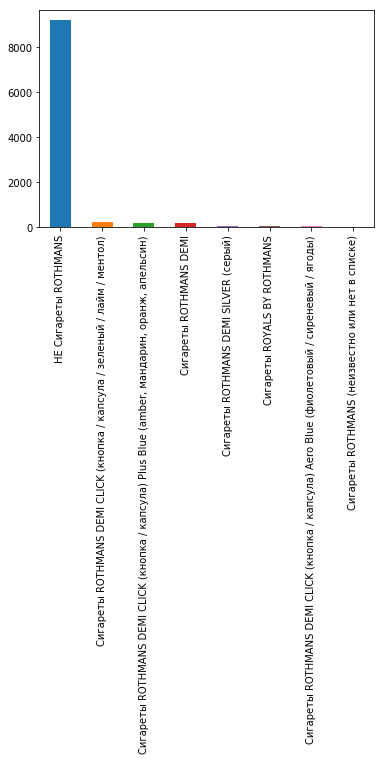

In [39]:
my_tags = df.result.unique()
df.result.value_counts().plot(kind="bar", rot=90)

С такой несбалансированностью можно утвержать, что все есть не сигареты и получить высокую accuracy (кстати давайте сразу найдем ее для наивного классификатора, не находящего сигареты).
Тем не менее, для проверки влияния изменения надо сотреть на какую-то цифру, которая характеризует сразу все классы, в этом отношении accuracy подойдет (интуитивно она супер понятна, в отличие от макроаука или ф1).
Но тобы было понятно, насколько плохо справляется классификатор с конкретными сигаретами, построим матрицу ошибок.

In [45]:
print('dummy accuracy = {0:.4g}'.format(len(df[df['result'] == 'НЕ Сигареты ROTHMANS'])/len(df)))

dummy accuracy = 0.9202


In [58]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(8)
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['name'])
    predictions = classifier.predict(data_features)
    target = data['result']
    evaluate_prediction(predictions, target)
    
def silent_evaluation(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['name'])
    predictions = classifier.predict(data_features)
    target = data['result']   
    return(accuracy_score(target, predictions))    
    

### Уберем очевидный мусор из текста и начнем с bag of words

In [46]:
# def tokenize_text(text):
#     tokens = []
#     for sent in nltk.sent_tokenize(text):
#         for word in nltk.word_tokenize(sent):
#             if len(word) < 2:
#                 continue
#             tokens.append(word.lower())
#     return tokens

In [41]:
nltk.download("stopwords")
#Create lemmatizer and stopwords list
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")
garbage = ['#', '$', '%', '&', "'", "''", "'1", "'s", '(', ')', '*', 
           '*пр', '+', ',', '-', '-2', '-4', '.', '...', 
           '/', '//', '/10/', '/100/', '/кнр/', '/мрц', '/натур', '/россия', '/россия/']
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords
              and token != " " 
              and token.strip() not in punctuation and not token.isdigit() 
              and token not in garbage]
    
    text = " ".join(tokens)  
    return text
    
preprocess_text("сигареты winston / blue / 125,00 руб")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'сигарета winston blue руб'

In [42]:
df2 = df.copy()
df2.loc[:,"name"] = df2.name.apply(lambda x: preprocess_text(x)) # требует много времени

In [20]:
print(df2.head(10))
numerator = (df['name'].apply(lambda x: len(x.split(' '))).sum() - df2['name'].apply(lambda x: len(x.split(' '))).sum())
denominator = df['name'].apply(lambda x: len(x.split(' '))).sum()
percent_words_del = 100*numerator/denominator
print('очистка от стопслов убрала {0:.2g}%'.format(percent_words_del))

                                        name                result
0                      вода аква минерал газ  НЕ Сигареты ROTHMANS
1                              сигарета keht  НЕ Сигареты ROTHMANS
2  сигарета стиль rose ssl jade жадэ розовый  НЕ Сигареты ROTHMANS
3                 мина вода нарзан 0.5 л пэт  НЕ Сигареты ROTHMANS
4                          пирожок печь мясо  НЕ Сигареты ROTHMANS
5                  сигарета winston blue руб  НЕ Сигареты ROTHMANS
6                 карамель палочка страйк 3г  НЕ Сигареты ROTHMANS
7                      шпатель 100мм сибртех  НЕ Сигареты ROTHMANS
8                          детский крем 40мл  НЕ Сигареты ROTHMANS
9                     туфля комфорт муж tofa  НЕ Сигареты ROTHMANS
очистка от стопслов убрала 11%


In [21]:
# насколько однородные данные в классе 'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула / зеленый / лайм / ментол)'?
print(df2[df2['result'] == 'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула / зеленый / лайм / ментол)']['name'].head(20))

76                                   ротманс деми капсула
96                                       ротмансдеми клик
117                                  ротманс деми клик шт
120                        сигарета ротманс деми клик руб
159                            сигарета ротманс деми клик
230                   сигарета ротманс деми клик ss мрц95
300                            сигарета ротманс деми клик
321                            сигарета ротманс деми клик
336                                     ротманс деми клик
410                                 ротманс деми клик мрц
462                       сигарета ротманс деми kлик1 пач
467                           сиг фильт ротманс деми клик
471         сигарета фильтр rothmans of london demi click
529                              сигара ротманс деми клик
672                             ротманс деми кнопка мрц95
674     сигарета rothmans demi click mentol compact ро...
776                                ротманс деми клик лайм
826           

### наблюдение 1.1
Английская k вместо русской к, click и клик, demi и деми. Нужно будет привести 'транслит' к одному виду.

In [54]:
train_data, test_data = train_test_split(df2, test_size=0.2, random_state=43)
# training 
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, max_features=5000) 
train_data_features = count_vectorizer.fit_transform(train_data['name'])

In [55]:
count_vectorizer.get_feature_names()[:30]

['!',
 '#',
 '$',
 '%',
 "'",
 "''",
 "''*",
 '(',
 ')',
 '*',
 '**',
 '****',
 '+',
 '++',
 '+-',
 ',',
 '-',
 '--',
 '.',
 '..',
 '/',
 '//',
 '0.05',
 '0.1',
 '0.10',
 '0.130',
 '0.15',
 '0.2',
 '0.21',
 '0.216']

In [22]:
# остался мусор
rest_garbage = ['!',  '#',  '$',  '%',  "'",  "''",  "''*",  '(',  ')',  '*',  '**',  '****', '+',  '++', '+-', ',', '-', '--',
 '.', '..', '/', '//', '-|', '...', '/-', '//-', '/|']

accuracy 0.985
confusion matrix
 [[1849    0    0    2    0    4    0    1]
 [   0    0    0    0    0    0    0    1]
 [   0    0   27    2    0    0    0    4]
 [   3    0    3   29    0    0    0    1]
 [   0    0    1    0   10    0    0    1]
 [   0    0    2    0    0   30    0    0]
 [   0    0    1    0    0    0   12    0]
 [   0    0    3    1    0    0    0   13]]
(row=expected, col=predicted)


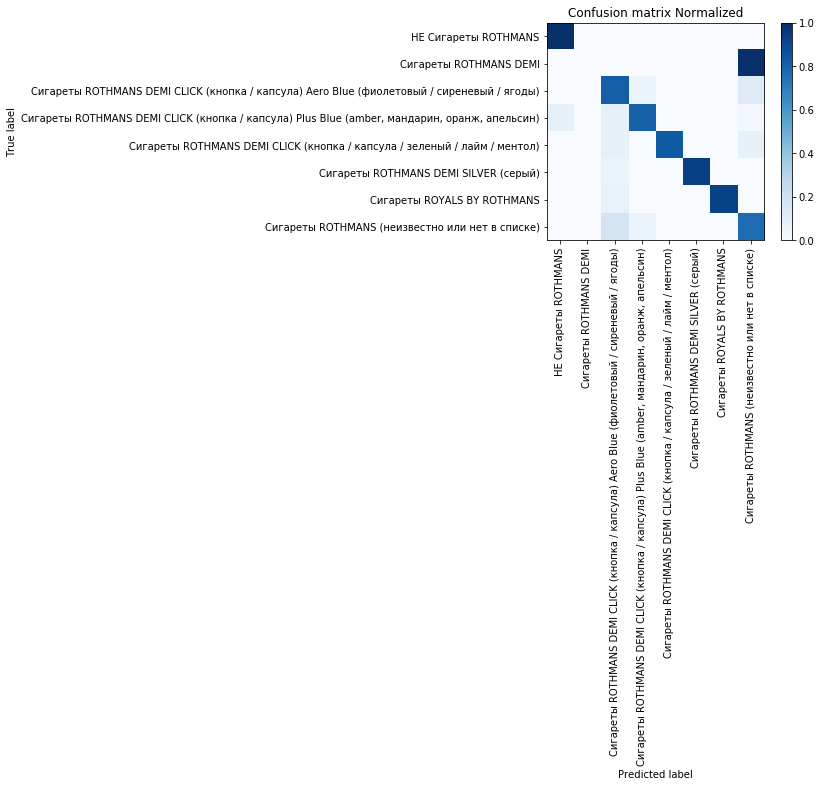

In [59]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['result'])
predict(count_vectorizer, logreg, test_data)

Теперь мешок слов будет новым baseline.У нас мало примеров, поэтому чтобы непереобучиться, будем делать честную кроссвалидацию на случайных подвыборках мощностью в 80% от исходного сета (получим связанные выборки). Получим среднюю оценку модели,
 используя т-критерий стьюдента (предварительно проверив нормальность качественно), будем проверять, как то или иное изменение будет влиять на метрику. 

In [28]:
average_acc = []
for i in range(50):
    train_data, test_data = train_test_split(df2, test_size=0.2, random_state=i)
# training 
    count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, max_features=5000) 
    train_data_features = count_vectorizer.fit_transform(train_data['name'])
    logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
    logreg = logreg.fit(train_data_features, train_data['result'])
    acc_i = silent_evaluation(count_vectorizer, logreg, test_data)
    average_acc += [acc_i]   

In [29]:
print('средняя accuracy = {0:.4g}'.format(np.mean(average_acc)))
print('СКО accuracy = {0:.4g}'.format(np.std(average_acc, ddof = 1)))

средняя accuracy = 0.9853
СКО accuracy = 0.00287


Проверяем то, как повлияет удаление слов из списка rest_garbage 

In [60]:
average_acc2 = []
for i in range(50):
    train_data, test_data = train_test_split(df2, test_size=0.2, random_state=i)
# training 
    count_vectorizer2 = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None,  stop_words=rest_garbage, max_features=5000) 
    train_data_features = count_vectorizer2.fit_transform(train_data['name'])
    
    logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
    logreg = logreg.fit(train_data_features, train_data['result'])
    acc_i = silent_evaluation(count_vectorizer2, logreg, test_data)
    average_acc2 += [acc_i]     

In [61]:
print('средняя accuracy = {0:.4g}'.format(np.mean(average_acc2)))
print('СКО accuracy = {0:.4g}'.format(np.std(average_acc2, ddof = 1)))

средняя accuracy = 0.986
СКО accuracy = 0.002798


Метрика чуть-чуть подросла с 0.9853 до 0.9860, но насколько значимо это отличие?

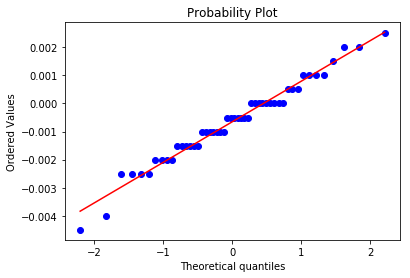

Shapiro-Wilk normality test, W-statistic: 0.977544, p-value: 0.453661


In [62]:
diff = [x-y for (x,y) in zip(average_acc,average_acc2)]
stats.probplot(diff, dist="norm", plot=pylab)
pylab.show()
print ("Shapiro-Wilk normality test, W-statistic: %f, p-value: %f" % stats.shapiro(diff))

В дальнейшем не станем параноидально везде проверять нормальность попарных разностей. 

In [63]:
stats.ttest_rel(average_acc, average_acc2)

Ttest_relResult(statistic=-3.223385378739939, pvalue=0.00225551793042964)

Будем считать, что удаление мусора из списка rest_garbage сработало. Новый baseline = 0.9860

accuracy 0.983
confusion matrix
 [[1808    0    0    1    4    0    0    0]
 [   0    0    2    0    0    0    0    1]
 [   0    0   37    4    1    0    2    2]
 [   0    0    3   48    0    0    0    0]
 [   0    0    0    1   12    0    0    0]
 [   0    0    1    2    0   35    0    0]
 [   1    0    2    0    0    0   17    0]
 [   0    0    3    4    0    0    0    9]]
(row=expected, col=predicted)


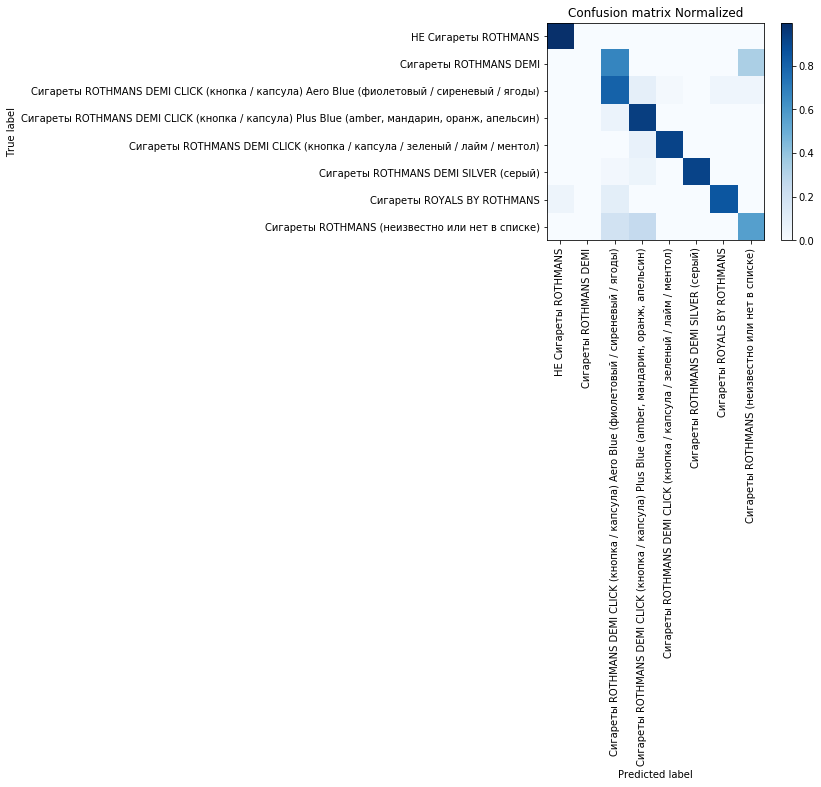

In [64]:
predict(count_vectorizer2, logreg, test_data)

Хуже всего обстоят дела с 2 типами сигарет: сиреневыми ягодными и с теми, которых нет в списке.
Посмотрим насколько однородные данные в ягодных сигаретах, и какие слова наиболее значимы для модели в в ягодном классе. 

In [68]:
print(df2[df2['result'] == 'Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Aero Blue (фиолетовый / сиреневый / ягоды)']['name'].head(15))

49                          ротманс деми клик аэро блю
447                                 ротманс деми ягода
588                          ротманс деми аэро капсула
943                              ротманс деми аэро блю
982                       ротманс деми фиол кнопка мрц
1045                     ротманс деми виноград аэро шт
1046                 сигарета ротманс деми клик фиолет
1068    ротманс деми слим блю аэро яга кнопка тв 95.00
1312                       rothmans demi капсула ягода
1365                   сигарета ротманс деми клик аэро
2072                   сигарета рот манс деми аэро мрц
2161         сигарета rothmans royals demi click berry
2330                           ротманс деми клик ягода
2571      сигарета фильтр rothmans aero blue demi clik
2595                               ротман деми аэрбить
Name: name, dtype: object


### наблюдение 1.2
Тут такая же история: click и клик, demi и деми. Частая ошибка - алгоритм принимает за ягодные за обычные Rothmans demi.
(транслитерация может помочь).
### наблюдение 2.1
Понятно, что народ пишет одно и то же название разными способами (рот манс и ротманс) вероятно, если бить имена собственные на куски, будет лучше.

In [65]:
def most_influential_words(vectorizer, genre_index=0, num_words=20):
    features = vectorizer.get_feature_names()
    max_coef = sorted(enumerate(logreg.coef_[genre_index]), key=lambda x:x[1], reverse=True)
    return [features[x[0]] for x in max_coef[:num_words]]    
# words for the fantasy genre
genre_tag_id = 2
print(my_tags[genre_tag_id])
most_influential_words(count_vectorizer2, genre_tag_id)

Сигареты ROTHMANS DEMI CLICK (кнопка / капсула) Aero Blue (фиолетовый / сиреневый / ягоды)


['рот',
 'ротменс',
 '1пачка',
 'ротмас',
 'фил',
 '46129185сигареты',
 'ротхманс',
 'ks',
 '100.00',
 '80р',
 '4мг',
 'cl',
 'длинный',
 'bat',
 '1п',
 '00р',
 'комп',
 'тв',
 'синий',
 'расти']

### Наблюдение 2.2
4мг - Это содержание никотина, видимо. Значит удалять меры весов не стоит. Но цены нужно убрать, поскольку во всех магазинах они разные.
###### =================================================================================================================

### Итак, сейчас есть 4 гипотезы, которые хочется проверить: 

#### 1) убрать цены и вообще все оставшиеся цифры, разделенные точкой (наблюдение 2.2)

#### 2) транскрипт (наблюдение 1.1 и 1.2)

#### 3) учесть факт, что одно и то же имя собственное может быть написано по-частям (наблюдение 2.1)
(Эту проблему может решить оптимизация параметров CountVectorizer. Что важнее: порядок слов или куски слов?)

#### 4) поискать оптимальную регуляризацию в лог регрессии

Надо идти именно в таком порядке. Начнем с уничтожения цен и вообще всех оставшихся цифр.

In [23]:
def preprocess_text2(text):
    a = text.translate(str.maketrans('', '', string.punctuation))
    b = ''.join([i for i in a if not i.isdigit()])
    tokens = []
    for sent in nltk.sent_tokenize(b):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 1:
                continue
            tokens.append(word.lower())
    return(' '.join(tokens))  
    
print(preprocess_text2('сигареты порох 100р всего 10 штук по 151.5р по 150,5р по 149,5 р'))

сигареты порох всего штук по по по


In [24]:
print('до удаления чисел')
df2[100:]['name'].head(20)

до удаление чисел


100                    табак mobihel спрей шт
101                пододеяльник поплин 1.5 сп
102                      печение овсяный 250г
103                простыня трикот резинка хк
104    оказание услуга договор комиссия 27.06
105                     c1307lr опора шаровой
106        сигарета ротманс деми сильвер 1пач
107                                  счет : (
108                  папка д тетры а5 черн шт
109                     вбд дп вода сок агуша
110                вода сенежский газ п 0.5 л
111          сигарета rothmans demi blue 100р
112         винстон супер слим сильвер россия
113                   пиво оболонь светлый 1л
114        сигарета винстон супер слим хs блю
115        мороженое дивушкино шоколад стакан
116                       оплата услуга связь
117                      ротманс деми клик шт
118                     олиджим таб 52г № бад
119                         чипсы pro 60г асс
Name: name, dtype: object

In [25]:
df3 = df2.copy()
df3.loc[:,"name"] = df3.name.apply(lambda x: preprocess_text2(x)) 
print('после удаления чисел')
print(df3[100:]['name'].head(20))

numerator = (df2['name'].apply(lambda x: len(x.split(' '))).sum() - df3['name'].apply(lambda x: len(x.split(' '))).sum())
denominator = df2['name'].apply(lambda x: len(x.split(' '))).sum()
percent_words_del = 100*numerator/denominator
print('очистка от чисел убрала {0:.2g}%'.format(percent_words_del))

после удаления чисел
100                табак mobihel спрей шт
101                пододеяльник поплин сп
102                       печение овсяный
103            простыня трикот резинка хк
104      оказание услуга договор комиссия
105                     clr опора шаровой
106     сигарета ротманс деми сильвер пач
107                                  счет
108                   папка тетры черн шт
109                 вбд дп вода сок агуша
110                    вода сенежский газ
111           сигарета rothmans demi blue
112     винстон супер слим сильвер россия
113                  пиво оболонь светлый
114    сигарета винстон супер слим хs блю
115    мороженое дивушкино шоколад стакан
116                   оплата услуга связь
117                  ротманс деми клик шт
118                       олиджим таб бад
119                         чипсы pro асс
Name: name, dtype: object
очистка от чисел убрала 16%


Отлично! убрали цифры и всякие значки. Объем слов уменьшился на 16%.

In [75]:
average_acc3 = []
for i in range(50):
    train_data, test_data = train_test_split(df3, test_size=0.2, random_state=i)
# training 
    count_vectorizer3 = CountVectorizer(
    tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words=rest_garbage, max_features=5000, analyzer="word") 
    train_data_features = count_vectorizer3.fit_transform(train_data['name'])
    
    logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
    logreg = logreg.fit(train_data_features, train_data['result'])
    acc_i = silent_evaluation(count_vectorizer3, logreg, test_data)
    average_acc3 += [acc_i]     

In [83]:
print('средняя accuracy = {0:.4g}'.format(np.mean(average_acc3)))
print('СКО accuracy = {0:.4g}'.format(np.std(average_acc3, ddof = 1)))
stats.ttest_rel(average_acc3, average_acc2)

средняя accuracy = 0.9883
СКО accuracy = 0.002669


Ttest_relResult(statistic=8.458170471193062, pvalue=3.839664915257485e-11)

Гипотеза с цифрами улучшила acc с 0.9860 до 0.9883. Новый baseline = 0,9883.

Поэтому в дальнейшем будем обрабатывать данные с удалением чисел.

Теперь проверим то, как исправление транслитерации на русский манер (rothmans -> ротманс) повлияет на метрики. При этом нужно делать это честно, не подстраиваясь только под сигареты.

In [ ]:
import transliterate

print(transliterate.translit('сигарета keht blue', reversed=None))

In [26]:
print('до исправления транслитерации')
df3['name'].head(10)

до исправления транслитерации


0                        вода аква минерал газ
1                                сигарета keht
2    сигарета стиль rose ssl jade жадэ розовый
3                         мина вода нарзан пэт
4                            пирожок печь мясо
5                    сигарета winston blue руб
6                      карамель палочка страйк
7                           шпатель мм сибртех
8                              детский крем мл
9                       туфля комфорт муж tofa
Name: name, dtype: object

In [27]:
def preprocess_text3(text):
    try:
        trans_text = transliterate.translit(text, reversed=None)
    except:
        trans_text = text 
        
    return(trans_text)  

df4 = df3.copy()
df4.loc[:,"name"] = df4.name.apply(lambda x: preprocess_text3(x))
print('после исправления транслитерации')
print(df4['name'].head(10))

после исправления транслитерации
0                        вода аква минерал газ
1                                сигарета keht
2    сигарета стиль rose ssl jade жадэ розовый
3                         мина вода нарзан пэт
4                            пирожок печь мясо
5                    сигарета winston blue руб
6                      карамель палочка страйк
7                           шпатель мм сибртех
8                              детский крем мл
9                       туфля комфорт муж tofa
Name: name, dtype: object


In [91]:
average_acc4 = []
for i in range(50):
    train_data, test_data = train_test_split(df4, test_size=0.2, random_state=i)
# training 
    count_vectorizer4 = CountVectorizer(
    tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words=rest_garbage, max_features=5000, analyzer="word") 
    train_data_features = count_vectorizer4.fit_transform(train_data['name'])
    
    logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
    logreg = logreg.fit(train_data_features, train_data['result'])
    acc_i = silent_evaluation(count_vectorizer4, logreg, test_data)    
    average_acc4 += [acc_i]     

In [86]:
print('средняя accuracy = {0:.4g}'.format(np.mean(average_acc4)))
print('СКО accuracy = {0:.4g}'.format(np.std(average_acc4, ddof = 1)))
stats.ttest_rel(average_acc3, average_acc4)

средняя accuracy = 0.989
СКО accuracy = 0.002487


Ttest_relResult(statistic=-2.2382313041419337, pvalue=0.029782897389425755)

Гипотеза с транслитом улучшила acc с 0.9883 до 0.9890. Теперь baseline = 0.9890

accuracy 0.9885
confusion matrix
 [[1810    0    0    1    2    0    0    0]
 [   0    0    2    0    0    0    0    1]
 [   0    0   43    1    1    0    0    1]
 [   1    0    3   47    0    0    0    0]
 [   0    0    0    0   13    0    0    0]
 [   0    0    1    2    0   35    0    0]
 [   1    0    2    0    0    0   17    0]
 [   0    0    1    3    0    0    0   12]]
(row=expected, col=predicted)


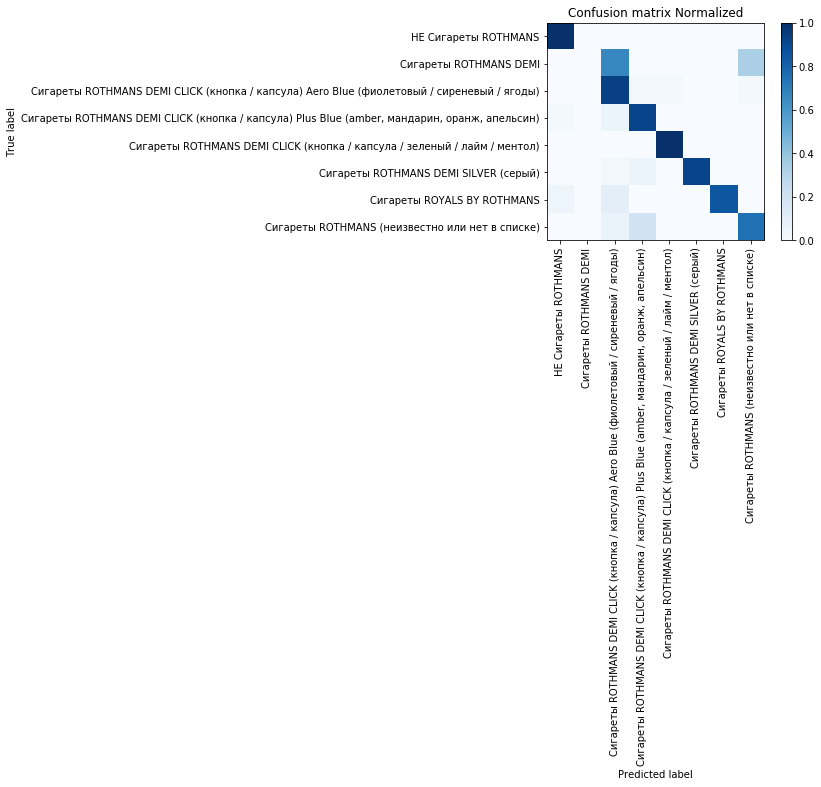

In [88]:
predict(count_vectorizer4, logreg, test_data)

Уничтожение цифр и исправление транслитерации улучшили ситуацию. Пока идей по части обработки исх данных не осталось. Теперь попробуем оптимизировать параметры CountVectorizer (ngram_range, df_min, analyzer). Чтобы не перегружать ноутбук мусором сразу оставлю оптимальный вариант: ngram_range = [2:5], analyzer = "char", df_min

In [48]:
# увеличим количество фич *10 (~объем словарного запаса предоставленного файла с тестовым)
average_acc5 = []
for i in range(50):
    train_data, test_data = train_test_split(df4, test_size=0.2, random_state=i)
# training 
    count_vectorizer5 = CountVectorizer(
    tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words=rest_garbage, max_features=50000, analyzer="word") 
    train_data_features = count_vectorizer5.fit_transform(train_data['name'])
    
    logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
    logreg = logreg.fit(train_data_features, train_data['result'])
    acc_i = silent_evaluation(count_vectorizer5, logreg, test_data)    
    average_acc5 += [acc_i]     

In [108]:
print('средняя accuracy = {0:.4g}'.format(np.mean(average_acc5)))
print('СКО accuracy = {0:.4g}'.format(np.std(average_acc5, ddof = 1)))
stats.ttest_rel(average_acc4, average_acc5) 

средняя accuracy = 0.9901
СКО accuracy = 0.002066


Ttest_relResult(statistic=-4.259773988065042, pvalue=9.246800128316217e-05)

Теперь baseline = 0.9901

In [111]:
average_acc7 = []
for i in range(50):
    train_data, test_data = train_test_split(df4, test_size=0.2, random_state=i)
# training 
    count_vectorizer6 = CountVectorizer(
    tokenizer=nltk.word_tokenize,
    ngram_range=([2,5]),
    min_df = 2, 
    preprocessor=None, stop_words=rest_garbage, max_features=50000, analyzer="char") 
    train_data_features = count_vectorizer6.fit_transform(train_data['name'])
    
    logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
    logreg = logreg.fit(train_data_features, train_data['result'])
    acc_i = silent_evaluation(count_vectorizer6, logreg, test_data)    
    average_acc7 += [acc_i]     

In [114]:
print('средняя accuracy = {0:.4g}'.format(np.mean(average_acc7)))
print('СКО accuracy = {0:.4g}'.format(np.std(average_acc7, ddof = 1)))
stats.ttest_rel(average_acc5, average_acc7) 

средняя accuracy = 0.9949
СКО accuracy = 0.001552


Ttest_relResult(statistic=-19.28089956561937, pvalue=1.5904938278174298e-24)

accuracy 0.9905
confusion matrix
 [[1812    0    0    1    0    0    0    0]
 [   0    0    2    0    0    0    0    1]
 [   0    0   43    0    1    0    0    2]
 [   0    0    3   48    0    0    0    0]
 [   0    0    0    1   12    0    0    0]
 [   0    0    0    2    0   36    0    0]
 [   1    0    2    0    0    0   17    0]
 [   0    0    1    2    0    0    0   13]]
(row=expected, col=predicted)


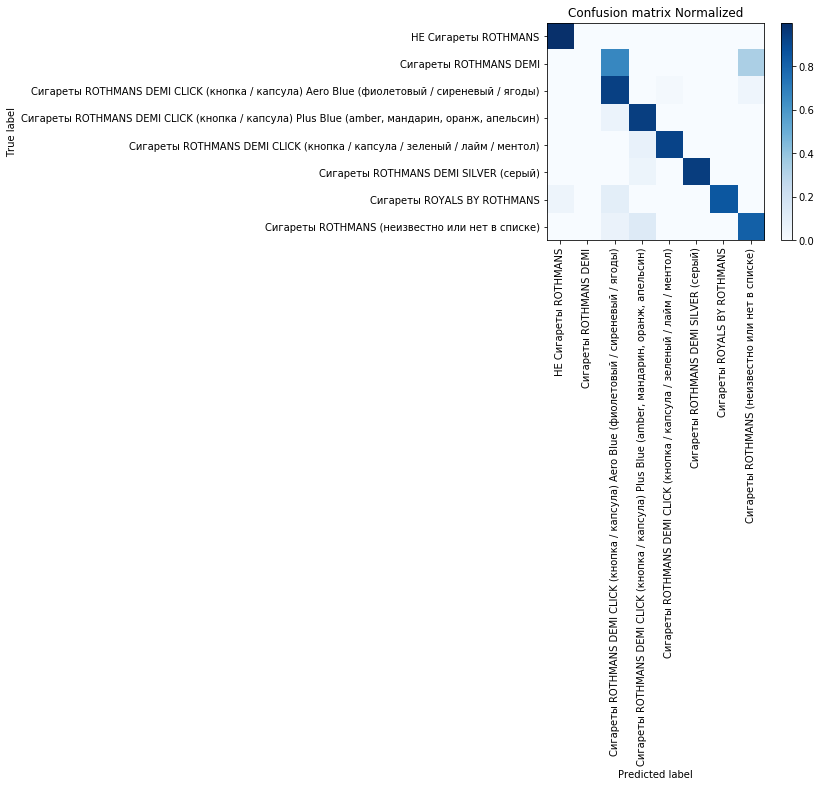

In [59]:
predict(count_vectorizer5, logreg, test_data)

### Финальная mean accuracy на скользящем контроле = 0.9949
Спойлер: дефолтные установки логрегрессии уже оптимальны, учет весов классов не дает прироста точности, наоборот модель начинает путать вид сигарет, которых нет в списке с нетабачными товарами. Хорошо бы иметь побольше данных. Исправлять вот эти 1-2 ошибки в матрице ошибок будет неправильно.

### Возникла идея: проверить то, как исправление опечаток (а они там есть) отразится на метрике. (По-хорошему это нужно делать сразу после удаления мусора, а не сейчас).  Пока не стану это делать.

In [47]:
from spellchecker import SpellChecker

spell = SpellChecker()

# find those words that may be misspelled
misspelled = spell.unknown(['something', 'is', 'hapenning', 'here'])
print(misspelled)

{'hapenning'}
